In [65]:
from sympy import *
from dtumathtools import *
from IPython.display import Markdown
from extras import print_delayer
import networkx as nx
init_printing(use_latex="mathjax" )
mdisplay = lambda x: display(Markdown(str(x)))
nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black", 'node_size':400}
p = print_delayer()

# Grafteoretisk Modellering af Netværk

## Opgave 1

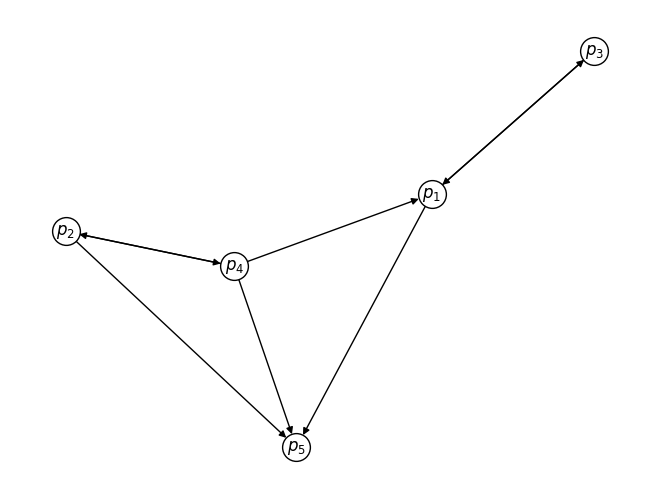

In [66]:
p1,p2,p3,p4,p5 = symbols('$p_1:6$')
V1 = {p1, p2, p3, p4, p5}
E1 = {(p1,p3), (p1,p5),(p2,p4),(p2,p5),(p3,p1),(p4,p1),(p4,p2),(p4,p5)}
W = nx.DiGraph()
W.add_nodes_from(V1, color="white")

W.add_edges_from(E1)
nx.draw(W,**nx_args)

## Opgave 2

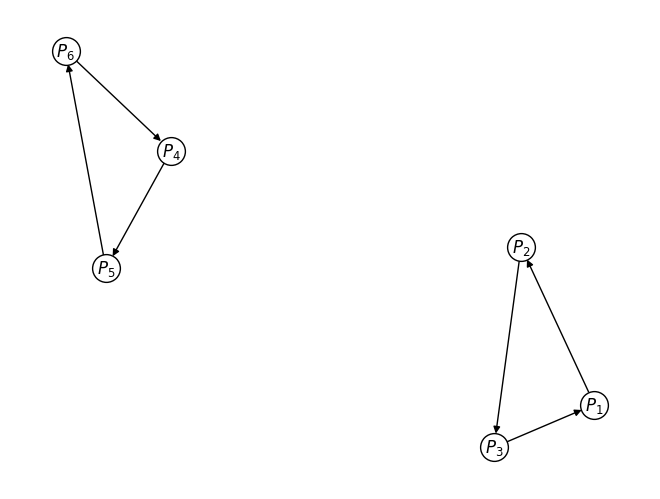

In [67]:
p1,p2,p3,p4,p5,p6 = symbols('$P_1:7$')
V2 = {p1, p2, p3, p4, p5, p6}
E2 = {(p1,p2), (p2,p3),(p3,p1),(p4,p5),(p5,p6),(p6,p4)}
W2 = nx.DiGraph()
W2.add_nodes_from(V2, color="white")

W2.add_edges_from(E2)
nx.draw(W2,**nx_args)

# Opgave 3
#

Jo flere komponenter der er i et netværk, jo svære bliver det at finde en specifik node. Faktisk er det helt umuligt at finde frem til en node i et komponent, hvis man er i et andet komponent til at begynde med. Der er altså ingen links fra den ene hjemmeside til den anden. 

##

In [68]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
W2 = {p1: {p2}, p2: {p3}, p3: {p1}, p4: {p5}, p5: {p6}, p6: {p4}}

Det kan tjekkes om en node i graphen ikke linker til andrer noder, ved at tjekke om nodens value i adjacency listen er den tomme mængde $\emptyset$

## Opgave 5

In [69]:
import numpy as np

# Input: n og k er ikke-negative heltal
# Output: web er en dictionary med n nøgler.
# Værdien af hver nøgle er en liste, der er en delmængde af nøglerne.
def make_web(n,k,kmin=0):
    assert(k < n), "k skal være mindre end n (da man ikke kan linke til sig selv)"
    assert(kmin <= k), "kmin skal være mindre end eller lig med k"
    keys = list(symbols(f"$p_0:{n}$")) 
    web = dict()
    
    for j in keys:
        numlinks = np.random.randint(kmin, k)
        key_choices = keys.copy()
        key_choices.remove(j)
        web[j] = set(np.random.choice(key_choices, numlinks))
    
    return web

print(make_web(4,3, 1))

{$p_0$: {$p_1$, $p_2$}, $p_1$: {$p_2$}, $p_2$: {$p_3$}, $p_3$: {$p_0$, $p_2$}}



## Opgave 6


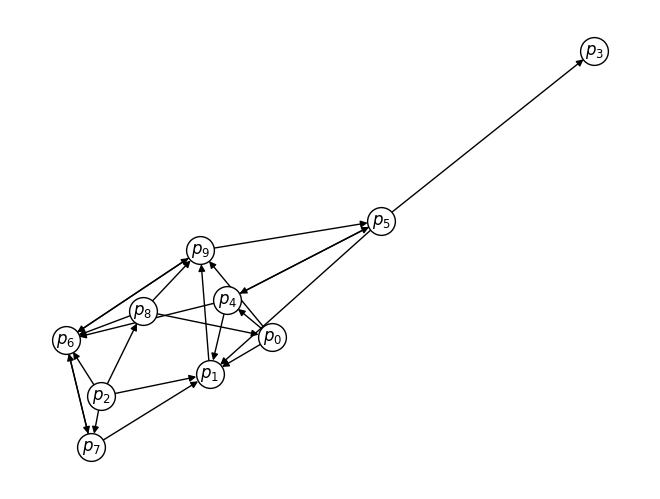

In [70]:
import matplotlib.pyplot as plt

def convert_to_nxgraph(web : dict):
    digraph = nx.DiGraph()
    digraph.add_nodes_from(web.keys())

    for page in web.keys():
        for link_to in web[page]:
            digraph.add_edge(page, link_to)

    return digraph

    # Input: netværk som dictionary
    # Output: Netværk visualiseret som graf
def visualize_graph(web : dict):
    
    digraph = convert_to_nxgraph(web)
    
    plt.figure()
    nx.draw(digraph, **nx_args)
    plt.plot()

visualize_graph(make_web(10, 5, 0))

# Link matricen og Random Surfer Modellen

## Opgave 7

In [71]:
def make_adjacency_matrix(graph):
    A = nx.adjacency_matrix(convert_to_nxgraph(graph))
    b = A.toarray().transpose()
    return b

In [72]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
display(Matrix(make_adjacency_matrix(W1)))




⎡0  0  1  1  0⎤
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎢1  0  0  0  0⎥
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎣1  1  0  1  0⎦

# Opgave 8

In [73]:
def make_link_matrix(graph: dict):

    adjacency_matrix : np.ndarray = make_adjacency_matrix(graph)

    n = adjacency_matrix.shape[0]
    link_matrix = np.zeros((n,n))
    
    for j in range(n):
        N = adjacency_matrix[:,j].sum()
        
        if N == 0:
            link_matrix[:,j] = 1 / n
            continue
            
        for i in range(n):
            if adjacency_matrix[i][j] == 1:
                link_matrix[i][j] = 1 / N
    
    return link_matrix
                

display(Matrix(make_link_matrix(W1)))


⎡0.0  0.0  1.0  0.333333333333333  0.2⎤
⎢                                     ⎥
⎢0.0  0.0  0.0  0.333333333333333  0.2⎥
⎢                                     ⎥
⎢0.5  0.0  0.0         0.0         0.2⎥
⎢                                     ⎥
⎢0.0  0.5  0.0         0.0         0.2⎥
⎢                                     ⎥
⎣0.5  0.5  0.0  0.333333333333333  0.2⎦

Matricerne har elementer samme sted, man tager antal 1-taller i hver søjle og sætter de tilsvarende elementer lig 1 / dette antal.
Hvis en søjle er en 0 vektor, sætter man alle elementer lig $\frac1N$

## Opgave 9

In [74]:
# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step(web, page):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
        
    if len(distribution) == 0:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step(W1, p1))

{$P_3$: 0.5, $P_5$: 0.5}


## Opgave 10

In [75]:
# Input: Et netværk som dictionary og antallet af skridt i random surf simuleringen
# Output: PageRank-værdier for hver side som en dictionary
def random_surf(web, n):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step(web, page)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf(W1,1000))

{$P_1$: 0.293, $P_2$: 0.09, $P_3$: 0.202, $P_4$: 0.104, $P_5$: 0.311}


## Opgave 11

In [76]:
def test_surf_model(model: callable, web: dict):
    output = ""
    for interval in [100, 1000, 10000]:
        output += cprint(f"interval: {interval}")
        for n in range(interval, interval+10, 1):
            output += cprint(model(web, n))
    return output


In [77]:
output = ""
output += cprint(test_surf_model(random_surf, W1))
output += cprint(test_surf_model(random_surf, W2))
mdisplay(output)

interval: 100

{$P_1$: 0.29, $P_2$: 0.1, $P_3$: 0.18, $P_4$: 0.15, $P_5$: 0.28}

{$P_1$: 0.3465346534653465, $P_2$: 0.019801980198019802, $P_3$: 0.18811881188118812, $P_4$: 0.1188118811881188, $P_5$: 0.32673267326732675}

{$P_1$: 0.2647058823529412, $P_2$: 0.10784313725490197, $P_3$: 0.1568627450980392, $P_4$: 0.14705882352941177, $P_5$: 0.3235294117647059}

{$P_1$: 0.3106796116504854, $P_2$: 0.11650485436893204, $P_3$: 0.22330097087378642, $P_4$: 0.0970873786407767, $P_5$: 0.2524271844660194}

{$P_1$: 0.3557692307692308, $P_2$: 0.04807692307692308, $P_3$: 0.25, $P_4$: 0.038461538461538464, $P_5$: 0.3076923076923077}

{$P_1$: 0.29523809523809524, $P_2$: 0.12380952380952381, $P_3$: 0.1619047619047619, $P_4$: 0.11428571428571428, $P_5$: 0.3047619047619048}

{$P_1$: 0.2358490566037736, $P_2$: 0.1320754716981132, $P_3$: 0.1792452830188679, $P_4$: 0.12264150943396226, $P_5$: 0.330188679245283}

{$P_1$: 0.3364485981308411, $P_2$: 0.06542056074766354, $P_3$: 0.27102803738317754, $P_4$: 0.08411214953271028, $P_5$: 0.24299065420560748}

{$P_1$: 0.3611111111111111, $P_2$: 0.037037037037037035, $P_3$: 0.2962962962962963, $P_4$: 0.05555555555555555, $P_5$: 0.25}

{$P_1$: 0.3577981651376147, $P_2$: 0.045871559633027525, $P_3$: 0.25688073394495414, $P_4$: 0.10091743119266056, $P_5$: 0.23853211009174313}

interval: 1000

{$P_1$: 0.312, $P_2$: 0.075, $P_3$: 0.218, $P_4$: 0.096, $P_5$: 0.299}

{$P_1$: 0.2967032967032967, $P_2$: 0.0989010989010989, $P_3$: 0.2047952047952048, $P_4$: 0.1028971028971029, $P_5$: 0.2967032967032967}

{$P_1$: 0.29740518962075846, $P_2$: 0.09481037924151696, $P_3$: 0.2155688622754491, $P_4$: 0.09381237524950099, $P_5$: 0.29840319361277445}

{$P_1$: 0.29910269192422734, $P_2$: 0.09770687936191426, $P_3$: 0.22233300099700898, $P_4$: 0.08873379860418744, $P_5$: 0.292123629112662}

{$P_1$: 0.2858565737051793, $P_2$: 0.10358565737051793, $P_3$: 0.1902390438247012, $P_4$: 0.11653386454183266, $P_5$: 0.30378486055776893}

{$P_1$: 0.31144278606965176, $P_2$: 0.09154228855721393, $P_3$: 0.2019900497512438, $P_4$: 0.09253731343283582, $P_5$: 0.3024875621890547}

{$P_1$: 0.3081510934393638, $P_2$: 0.09045725646123261, $P_3$: 0.2047713717693837, $P_4$: 0.110337972166998, $P_5$: 0.28628230616302186}

{$P_1$: 0.30486593843098314, $P_2$: 0.09632571996027806, $P_3$: 0.21648460774577954, $P_4$: 0.10228401191658391, $P_5$: 0.2800397219463754}

{$P_1$: 0.2876984126984127, $P_2$: 0.10218253968253968, $P_3$: 0.20337301587301587, $P_4$: 0.1111111111111111, $P_5$: 0.29563492063492064}

{$P_1$: 0.29732408325074333, $P_2$: 0.10406342913776016, $P_3$: 0.20812685827552033, $P_4$: 0.1159563924677899, $P_5$: 0.2745292368681863}

interval: 10000

{$P_1$: 0.2976, $P_2$: 0.0951, $P_3$: 0.2071, $P_4$: 0.105, $P_5$: 0.2952}

{$P_1$: 0.298970102989701, $P_2$: 0.09659034096590341, $P_3$: 0.20837916208379162, $P_4$: 0.10638936106389361, $P_5$: 0.2896710328967103}

{$P_1$: 0.3032393521295741, $P_2$: 0.09018196360727855, $P_3$: 0.20985802839432113, $P_4$: 0.10247950409918016, $P_5$: 0.29424115176964605}

{$P_1$: 0.2954113765870239, $P_2$: 0.09737078876337099, $P_3$: 0.20383884834549634, $P_4$: 0.10986703988803359, $P_5$: 0.2935119464160752}

{$P_1$: 0.3024790083966413, $P_2$: 0.09486205517792883, $P_3$: 0.20571771291483407, $P_4$: 0.10475809676129548, $P_5$: 0.2921831267493003}

{$P_1$: 0.296351824087956, $P_2$: 0.09825087456271864, $P_3$: 0.20509745127436282, $P_4$: 0.10574712643678161, $P_5$: 0.2945527236381809}

{$P_1$: 0.30691585048970615, $P_2$: 0.08994603238057165, $P_3$: 0.21507095742554466, $P_4$: 0.10283829702178693, $P_5$: 0.28522886268239056}

{$P_1$: 0.3068851803737384, $P_2$: 0.09263515539122615, $P_3$: 0.213250724492855, $P_4$: 0.10302788048366143, $P_5$: 0.284201059258519}

{$P_1$: 0.30455635491606714, $P_2$: 0.09362509992006394, $P_3$: 0.21562749800159872, $P_4$: 0.10261790567545963, $P_5$: 0.28357314148681056}

{$P_1$: 0.3085223299030872, $P_2$: 0.0922170046957738, $P_3$: 0.21051054051353782, $P_4$: 0.10480567489259666, $P_5$: 0.2839444499950045}



interval: 100

{$P_1$: 0.33, $P_2$: 0.34, $P_3$: 0.33, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33663366336633666, $P_2$: 0.33663366336633666, $P_3$: 0.32673267326732675, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3300970873786408, $P_5$: 0.3300970873786408, $P_6$: 0.33980582524271846}

{$P_1$: 0.33653846153846156, $P_2$: 0.3269230769230769, $P_3$: 0.33653846153846156, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.33962264150943394, $P_2$: 0.330188679245283, $P_3$: 0.330188679245283, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3364485981308411, $P_2$: 0.32710280373831774, $P_3$: 0.3364485981308411, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3302752293577982, $P_2$: 0.3302752293577982, $P_3$: 0.3394495412844037, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

interval: 1000

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.333, $P_5$: 0.334, $P_6$: 0.333}

{$P_1$: 0.3336663336663337, $P_2$: 0.3336663336663337, $P_3$: 0.33266733266733267, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3339980059820538, $P_2$: 0.33300099700897307, $P_3$: 0.33300099700897307, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33266932270916333, $P_2$: 0.3336653386454183, $P_3$: 0.3336653386454183, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33399602385685884, $P_5$: 0.33300198807157055, $P_6$: 0.33300198807157055}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3326713008937438, $P_5$: 0.3336643495531281, $P_6$: 0.3336643495531281}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.333994053518335, $P_5$: 0.3330029732408325, $P_6$: 0.3330029732408325}

interval: 10000

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333, $P_5$: 0.3333, $P_6$: 0.3334}

{$P_1$: 0.33326667333266674, $P_2$: 0.33336666333366666, $P_3$: 0.33336666333366666, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333999800059982, $P_2$: 0.3333000099970009, $P_3$: 0.3333000099970009, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33336665333866455, $P_5$: 0.33336665333866455, $P_6$: 0.33326669332267095}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.3333000199880072, $P_2$: 0.3333999600239856, $P_3$: 0.3333000199880072, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33336664334965527, $P_5$: 0.33336664334965527, $P_6$: 0.3332667133006895}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.33339994005395146, $P_2$: 0.33330002997302427, $P_3$: 0.33330002997302427, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}





Den varierer meget, selv små skridt i iterations størrelsen varierer ret meget.
Størrelsesordnerne er dog ca. det samme, og den bliver mere konsistent desto højere skridt iterations størrelsen er.

## Opgave 12


In [78]:
import random

# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step_damp(web, page, d):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
    
    if len(distribution) == 0 or random.random() >= d:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step_damp(W1, p1, 0.85))

{$P_3$: 0.5, $P_5$: 0.5}


In [79]:
def random_surf_damp(web, n, d):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step_damp(web, page, d)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf_damp(W1,1000, 0.85))

{$P_1$: 0.282, $P_2$: 0.11, $P_3$: 0.186, $P_4$: 0.138, $P_5$: 0.284}


# Opgave 13

In [80]:
dampening_factor = 0.85
output = ""
output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W1))
# output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W2))
mdisplay(output)

interval: 100

{$P_1$: 0.24, $P_2$: 0.11, $P_3$: 0.19, $P_4$: 0.11, $P_5$: 0.35}

{$P_1$: 0.2871287128712871, $P_2$: 0.16831683168316833, $P_3$: 0.1782178217821782, $P_4$: 0.12871287128712872, $P_5$: 0.2376237623762376}

{$P_1$: 0.27450980392156865, $P_2$: 0.10784313725490197, $P_3$: 0.22549019607843138, $P_4$: 0.1568627450980392, $P_5$: 0.23529411764705882}

{$P_1$: 0.3106796116504854, $P_2$: 0.1262135922330097, $P_3$: 0.17475728155339806, $P_4$: 0.13592233009708737, $P_5$: 0.2524271844660194}

{$P_1$: 0.23076923076923078, $P_2$: 0.16346153846153846, $P_3$: 0.19230769230769232, $P_4$: 0.14423076923076922, $P_5$: 0.2692307692307692}

{$P_1$: 0.26666666666666666, $P_2$: 0.10476190476190476, $P_3$: 0.23809523809523808, $P_4$: 0.12380952380952381, $P_5$: 0.26666666666666666}

{$P_1$: 0.29245283018867924, $P_2$: 0.1320754716981132, $P_3$: 0.16981132075471697, $P_4$: 0.16037735849056603, $P_5$: 0.24528301886792453}

{$P_1$: 0.24299065420560748, $P_2$: 0.14018691588785046, $P_3$: 0.14953271028037382, $P_4$: 0.1308411214953271, $P_5$: 0.3364485981308411}

{$P_1$: 0.32407407407407407, $P_2$: 0.07407407407407407, $P_3$: 0.24074074074074073, $P_4$: 0.046296296296296294, $P_5$: 0.3148148148148148}

{$P_1$: 0.29357798165137616, $P_2$: 0.09174311926605505, $P_3$: 0.1834862385321101, $P_4$: 0.12844036697247707, $P_5$: 0.30275229357798167}

interval: 1000

{$P_1$: 0.279, $P_2$: 0.109, $P_3$: 0.185, $P_4$: 0.139, $P_5$: 0.288}

{$P_1$: 0.2917082917082917, $P_2$: 0.0989010989010989, $P_3$: 0.2097902097902098, $P_4$: 0.12687312687312688, $P_5$: 0.2727272727272727}

{$P_1$: 0.27245508982035926, $P_2$: 0.12275449101796407, $P_3$: 0.18762475049900199, $P_4$: 0.1317365269461078, $P_5$: 0.28542914171656686}

{$P_1$: 0.26321036889332006, $P_2$: 0.1156530408773679, $P_3$: 0.193419740777667, $P_4$: 0.13559322033898305, $P_5$: 0.292123629112662}

{$P_1$: 0.300796812749004, $P_2$: 0.10458167330677291, $P_3$: 0.21812749003984064, $P_4$: 0.10856573705179283, $P_5$: 0.2679282868525896}

{$P_1$: 0.29054726368159206, $P_2$: 0.1044776119402985, $P_3$: 0.2109452736318408, $P_4$: 0.10845771144278607, $P_5$: 0.2855721393034826}

{$P_1$: 0.2813121272365805, $P_2$: 0.10934393638170974, $P_3$: 0.2077534791252485, $P_4$: 0.1272365805168986, $P_5$: 0.27435387673956263}

{$P_1$: 0.2740814299900695, $P_2$: 0.10724925521350546, $P_3$: 0.19563058589870905, $P_4$: 0.1221449851042701, $P_5$: 0.30089374379344586}

{$P_1$: 0.26884920634920634, $P_2$: 0.12003968253968254, $P_3$: 0.19543650793650794, $P_4$: 0.14087301587301587, $P_5$: 0.2748015873015873}

{$P_1$: 0.29137760158572845, $P_2$: 0.10703666997026759, $P_3$: 0.19821605550049554, $P_4$: 0.12487611496531219, $P_5$: 0.27849355797819625}

interval: 10000

{$P_1$: 0.2743, $P_2$: 0.1207, $P_3$: 0.1913, $P_4$: 0.1333, $P_5$: 0.2804}

{$P_1$: 0.28347165283471654, $P_2$: 0.1095890410958904, $P_3$: 0.19408059194080593, $P_4$: 0.13018698130186981, $P_5$: 0.2826717328267173}

{$P_1$: 0.28054389122175566, $P_2$: 0.11697660467906419, $P_3$: 0.1934613077384523, $P_4$: 0.1255748850229954, $P_5$: 0.28344331133773243}

{$P_1$: 0.2867139858042587, $P_2$: 0.110666799960012, $P_3$: 0.1964410676796961, $P_4$: 0.1218634409677097, $P_5$: 0.2843147055883235}

{$P_1$: 0.2810875649740104, $P_2$: 0.11635345861655338, $P_3$: 0.19702119152339065, $P_4$: 0.1256497401039584, $P_5$: 0.2798880447820872}

{$P_1$: 0.2783608195902049, $P_2$: 0.11074462768615692, $P_3$: 0.20179910044977512, $P_4$: 0.12823588205897052, $P_5$: 0.28085957021489255}

{$P_1$: 0.27903258045172896, $P_2$: 0.11313212072756346, $P_3$: 0.1943833699780132, $P_4$: 0.13411952828303017, $P_5$: 0.2793324005596642}

{$P_1$: 0.2828020385729989, $P_2$: 0.11641850704506845, $P_3$: 0.19606275607075047, $P_4$: 0.12900969321474967, $P_5$: 0.2757070050964325}

{$P_1$: 0.28007593924860114, $P_2$: 0.111810551558753, $P_3$: 0.19664268585131894, $P_4$: 0.12639888089528378, $P_5$: 0.28507194244604317}

{$P_1$: 0.2747527225497053, $P_2$: 0.12029173743630732, $P_3$: 0.19072834448995904, $P_4$: 0.13347986811869317, $P_5$: 0.2807473274053352}





Nu kan man se at man får et bedere estimat på pageranken for grafer med flere komponenter.

# Rekursiv Model og Matrix Formulering

## Opgave 14

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)} + \left[ d\sum_{s \in Sinks(W)}\frac{PR_{n}(s)}{N} \right]
\end{equation*}

Første led er sandsynligheden af at man kommer fra en tilfældig hjemmeside, hvor (1-d) er sandsynlighed for at dæmpningen sker. 1/N er sandsynlighen for at P sker. 
Andet led er sandsynlighedn for at man kommer (direkte) fra en anden hjemmeside (d). Ganget med for ethvert hjemmeside der peger på P (q), ganget med sandsynligheden for at man er på q, ganget med chancen for at man trykker på p. 

## Opgave 15

In [81]:
def rank_update(web: dict, page_ranks: dict, page, d):

        """
        Opdaterer værdien af PageRank for en side baseret på den rekursive formel
        Sider uden udgående links --->(sinks)<--- behandles som om de linker til alle sider på nettet.

        Input: 
            web og PageRanks er dictionaries som i outputtet fra "make_web" og "random_surf",
            page er nøglen til den side, hvis rank vi ønsker at opdatere, og
            d er dampingfaktoren.
        Output: 
            PageRank opdateres i henhold til ovenstående formel,
            og denne funktion returnerer et float "increment", den (absolutte) forskel
            mellem den tidligere værdi og den opdaterede værdi af PR(p).
        """
        # inbound_page is the same as q, in the original equation
        # lenth of web.keys is the same as N
        
        # for random pages
        new_page_rank = (1-d)* 1 / len(web)
        
        # for inbound web pages
        new_page_rank += d * sum([
              page_ranks[inbound_page]/len(web[inbound_page]) 
              for inbound_page in web 
              if page in web[inbound_page]
              ])
        
        # for sinks
        new_page_rank += d * sum([
              page_ranks[sink]/len(web) 
              for sink in web 
              if len(web[sink]) == 0
              ])

        return new_page_rank - page_ranks[page]

def recursive_page_rank(web : dict, stopvalue=0.0001, max_iterations=200, d=0.85):
    """
    Implementerer den rekursive version af PageRank-algoritmen ved først at oprette
    en PageRank på 1/N til alle sider (hvor N er det samlede antal sider)
    og derefter anvende "rank_update" gentagne gange, indtil en af de to stopbetingelser
    er opnået:
    stopbetingelse 1: den maksimale ændring fra trin n til trin (n+1) over alle PageRank
    er mindre end stopværdien,
    Stopbetingelse 2: antallet af iterationer har nået "max_iterations".

    Input: web er et dictionary som i outputtet af "make_web", d er dæmpningen,
    stopvalue er et positivt float, max_iterations er et positivt heltal.
    """

    page_ranks = dict()
    for page in web:
        page_ranks[page] = 1/len(web)

    for iteration in range(max_iterations):
        increments = dict()
        
        for page in web:
            increments[page]=rank_update(web,page_ranks,page,d)
        
        if max([ abs(v) for v in increments.values()]) <= stopvalue:
            break
        
        for page in increments:
            page_ranks[page] += increments[page]

    return page_ranks, iteration+1

mdisplay(recursive_page_rank(W1, max_iterations=100, stopvalue=1e-6, d=1))


({$P_1$: 0.30232599878340827, $P_2$: 0.09302332921588996, $P_3$: 0.20930209908496478, $P_4$: 0.1046511985292208, $P_5$: 0.2906973743865164}, 30)

# Opgave 16

Argumentér for at (▲) kan omskrives til (■).

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)}
\end{equation*}

Vi kigger på række $i$ i matrix formlen

$$
x_{n+1} = (1-d) \frac{1}{N} \pmb{e} + d \pmb{L} {x_n}
\\
= (1-d) \frac{1}{N} \pmb{e} + d 
\begin{bmatrix}
\pmb{L}_{1,1} \cdot PR_{n}(p_0) + \pmb{L}_{1,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{1,N} \cdot PR_{n}(p_N) 
\\
\pmb{L}_{2,1} \cdot PR_{n}(p_0) + \pmb{L}_{2,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{2,N} \cdot PR_{n}(p_N)
\\
\vdots
\\
\pmb{L}_{N,1} \cdot PR_{n}(p_0) + \pmb{L}_{N,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{N,N} \cdot PR_{n}(p_N)
\end{bmatrix}
$$

I følge definitionen af link matricen vil alle elementer på række $i$ have værdi $\frac{1}{deg^+(p_j)}$ hvis den er inbound på $p_i$ og ellers $0$, altså passer det med summen i (▲)

$$
\pmb{x}_{n+1} =
\begin{bmatrix}
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{1})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{2})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
\vdots 
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{n})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\end{bmatrix}
$$

Her ses det hver række i $\pmb{x}_{n+1}$ stemmer overens med den rekursive formel (▲)

## Opgave 17

In [82]:
def modified_link_matrix(web: dict, d=0.85):

    # Input: web (dictionary), pagelist (liste over nøgler), d (dæmpningsfaktor)
    # Output: d*A^T + (1-d)*E/N
    
    # A: NxN numpy array, hvor række j har ikke-nul elementer i søjler, som side j linker til.
    # Hvis side j ikke linker til nogen, får alle elementer i række j værdien 1/N.
    # E: np.ones([N,N])
    
    # A er en Transponeret link-matrice ifølge formlen (BØR MÅSKE ÆNDRES)
    A = make_link_matrix(web).T
    N = len(web)
    
    E = np.ones([N,N])
    
    return d*A.T + (1-d)*E/N


In [83]:
Matrix(modified_link_matrix(W1)),Matrix(modified_link_matrix(W2))


⎛                                              ⎡0.025  0.025  0.875  0.025  0. ↪
⎜⎡0.03   0.03   0.88  0.313333333333333  0.2⎤  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.875  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.03   0.03  0.313333333333333  0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.875  0.025  0.025  0. ↪
⎜⎢0.455  0.03   0.03        0.03         0.2⎥, ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.455  0.03        0.03         0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.875  0. ↪
⎜⎣0.455  0.455  0.03  0.313333333333333  0.2⎦  ⎢                               ↪
⎝                                              ⎣0.025  0.025  0.025  0.025  0. ↪

↪ 025  0.025⎤⎞
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.875⎥⎟
↪  

## Opgave 18

Hver søjle i L summer til 1, det vil sige at hver søjle summer til d, efter som vi ganger den med d.

Hvis vi summer for $\frac{1-d}{N}\pmb{E}_N$, og da E er en N gange N matrice med 1, taller. Vil vi så få summen af en søjle til at være $(\frac{1-d}{N})N=1-d$

Da $d+(1-d)=1$ summer alle søjler altså til 1.


In [ ]:
a,b,C =  symbols("a b C")

A = Matrix([
	[1,2,3],
	[4,5,6],
	[7,8,9],
])
B = Matrix([
	[a],
	[b],
	[c],
])



C = A*B display
display(C)




NameError: name 'printt' is not defined